<a href="https://colab.research.google.com/github/Xylemeister/Accelither/blob/main/Copy_of_06_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning

In this notebook we will train a network that will produce a good feature representation for the MNIST images. In this case, however, we will not use the labels available in the dataset to learn a label predictor $g$. We will approach the problem in an unsupervised manner by using the autoencoder method explained in the lecture. Hence, given an image $x$ from MNIST, we will encode it (using an encoder $\phi$) to a lower dimensionality vector $\phi(x)$, for example using only 2 values. Then, we will decode the lower dimensionality vector using a decoder $\psi$, and then minimize a reconstruction error. In this notebook, we will use the $l_2$-norm as reconstruction metric: we will minimize $||x - \psi(\phi(x))||^2$. Usually, the encoder $\phi$ and the decoder $\psi$ have a mirrored architecture. The following figure from the slides summarizes the idea.

<a href="https://ibb.co/0hhQ3Zt"><img src="https://i.ibb.co/6ggN5bB/Screenshot-from-2019-02-14-14-49-24.png" alt="Screenshot-from-2019-02-14-14-49-24" border="0"></a>

In [1]:
import os
import time

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import backend, callbacks, datasets, layers, models, optimizers, utils

**Loading the dataset**

As usual, we load the dataset and import some necessary modules. Both encoder $\phi$ and decoder $\psi$ will use `Dense` layers (with some activation functions in some cases), so we load the data in an array form in this tutorial.

In [2]:
num_classes = 10
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train= x_train.astype('float32')
x_test= x_test.astype('float32')

x_train /= 255.
x_test /= 255.

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Linear Autoencoder
In our first approach we do not use any activation function, hence the model is completely linear. We encode the input flattened image of dimensionality $784$ ($28\times28$) in a vector of 2 dimensions, and then decode it back to the $784$ vector. Even though the design autoencoder is of low capacity and the representation is constrained to dimensionality 2, we hope to see some meaningful features. To build our linear autoencoder, we first design a linear model using `Sequential()` and a couple of `Dense` layers. Notice how we can give a name to a layer by using the `name` argument. In this case, we give the name `representation` to the layer that encodes the input vector in only two dimensions. If you design your own network in this tutorial, you should use the `name='representation'` argument as we will use it to retrieve the representation vectors $\phi(x)$ from any arbitrary input data $x$.

In [3]:
model = models.Sequential([
    layers.Input(shape=(28**2,)),
    layers.Dense(2, name='representation'),
    layers.Dense(784),
])

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
model.summary()

epochs = 10
validation_split = 0.1
history = model.fit(x_train, x_train, batch_size=128,
          epochs=epochs, validation_split=validation_split)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ representation (Dense)               │ (None, 2)                   │           1,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 784)                 │           2,352 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,922 (15.32 KB)

 Trainable params: 3,922 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0576 - val_mse: 0.0576
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0574 - val_mse: 0.0574
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0569 - val_mse: 0.0569
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.0565 - val_mse: 0.0565
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

Now, we will see if we have learnt a good representation of the images by using this linear autoencoder. First, let's check the MSE in the test set.



In [4]:
# Evaluates model in the given metric (MSE in this case)
print('Test MSE obtained is {:.4f}'.format(model.evaluate(x_test, x_test)[0]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0545 - mse: 0.0545
Test MSE obtained is 0.0558


We have an MSE of around 0.056 in the test set. It may be hard to know if this value means a good reconstruction or not, but we can use the value to compare the performance of our linear autoencoder to other models. To have a better understanding of what this value means qualitatively, let's plot some images, along with the corresponding MSE.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


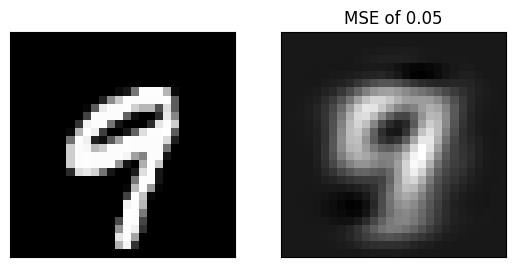

In [5]:
def plot_recons_original(image, label, model, size_image=(28,28)):
  ## Function used to plot image x and reconstructed image \psi\phi(x)
  # Reshape (just in case) and predict using model
  if len(image.shape) == 1:
    image = image.reshape(1, -1)
  reconst_image = model.predict(image)
  # Evaluate MSE to also report it in the image
  mse = model.evaluate(image, image, verbose=0)
  # Create a figure with 1 row and 2 columns
  plt.subplots(1,2)
  # Select first image in the figure
  ax = plt.subplot(121)
  # Plot image x
  plt.imshow(image.reshape(size_image[0],size_image[1]), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Select second image in the figure
  ax = plt.subplot(122)
  # Plot reconstructed image
  plt.imshow(reconst_image.reshape(size_image[0],size_image[1]), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Set a title to the current axis (second figure)
  plt.title('MSE of {:.2f}'.format(mse[0]))
  plt.show()

# Select a random index from the test set
ind = np.random.randint(x_test.shape[0] -  1)
plot_recons_original(x_test[ind], y_test[ind], model)

We see how the reconstructed images look in most cases blurry, due to the autoencoder $\psi(\phi(x))$ not having enough representation capacity. In Task 1, you will try to improve the model by adding some non-linearities/more layers. Now, let's check how the feature vectors of the simple linear autoencoder we just trained are distributed in the representation space.

## Representation Space
If we have a good feature representation, we hope to see in the representation space clusters of images sharing visual similarities in the image space. For example, images from the same class should be close to each other as they are visually similar.

To check how the features are distributed in the representation space, we forward the images from the test set to the autoencoder and retrieve the representation $\phi(x)$ in the layer with `name='representation'`. As the vector only has dimensionality 2 (we used `Dense(2...)`), we do not need to apply any dimensionality reduction technique to plot it.

We first compute the representation of the images from the MNIST test set using the `predict_representation` function. The function uses the name we gave to the layer to retrieve the representation vector, it forms a new model that instead of doing $\psi(\phi(x))$ it only computes $\phi(x)$.

In [6]:
def predict_representation(model, data, layer_name='representation'):
  ## We form a new model. Instead of doing \psi\phi(x), we only take \phi(x)
  ## To do so, we use the layer name
  intermediate_layer_model = models.Model(inputs=model.layers[0].input,
                                   outputs=model.get_layer(layer_name).output)
  representation = intermediate_layer_model.predict(data)
  representation = representation.reshape(representation.shape[0], -1)
  return representation

representation = predict_representation(model, x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Now, we plot the computed representation for the test images in a 2D scatter plot. We also assign in the scatter plot different colours to the points depending on their class label.

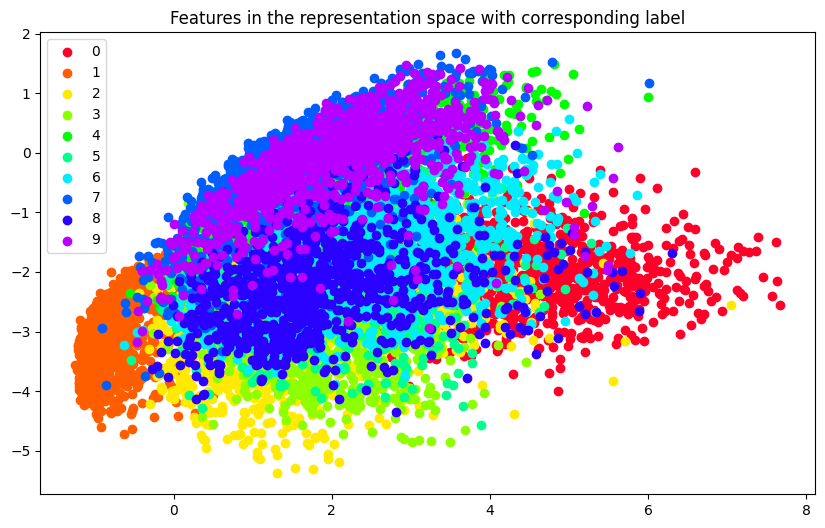

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Features in the representation space with corresponding label'}>)

In [7]:
def plot_representation_label(representation, labels, plot3d=0):
  ## Function used to plot the representation vectors and assign different
  ## colors to the different classes

  # First create the figure
  fig, ax = plt.subplots(figsize=(10,6))
  # In case representation dimension is 3, we can plot in a 3d projection too
  if plot3d:
    ax = fig.add_subplot(111, projection='3d')

  # Check number of labels to separate by colors
  n_labels = labels.max() + 1
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_labels)) for i in range(n_labels)])
  # Loop is to plot different color for each label
  for l in range(n_labels):
    # Only select indices for corresponding label
    ind = labels == l
    if plot3d:
      ax.scatter(representation[ind, 0], representation[ind, 1],
                 representation[ind, 2], label=str(l))
    else:
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(l))
  ax.legend()
  plt.title('Features in the representation space with corresponding label')
  plt.show()
  return fig, ax

plot_representation_label(representation, y_test)

The scatter plot shows that our linear autoencoder generates representations that are mostly clustered by class. However, some of the classes seem to overlap with each other, and some classes are more clustered than others. For example, the class `1`is well clustered, but the class `9` seems to overlap greatly with the class `7`.  The class `8` is also quite spread out, with some of the features closer to the features of the class `1`, some others closer to the class `6` or `0`.

## Clustering the Data
We have learnt a linear autoencoder capable of producing meaningful representations, and we also plotted it in the last section. We saw how the representations for the different images sharing the same label were close to each other without actually using the label information in the training process. Now, let's do a quick experiment to see how well clustered are the features. We will use a clustering method on these features, and then we will assign each of the clusters to the majority class (i.e., the most represented class in the cluster). We want to check what kind of accuracy we would have using this simple classification method as a way to understand how well clustered they are.

First, let's now cluster the features using a standard technique called K-Means. A good guess is to use the same number of clusters as classes, in this case we use 10 clusters. Then, as we mentioned, assign each of the clusters to the majority class and we compute the accuracy of this method.

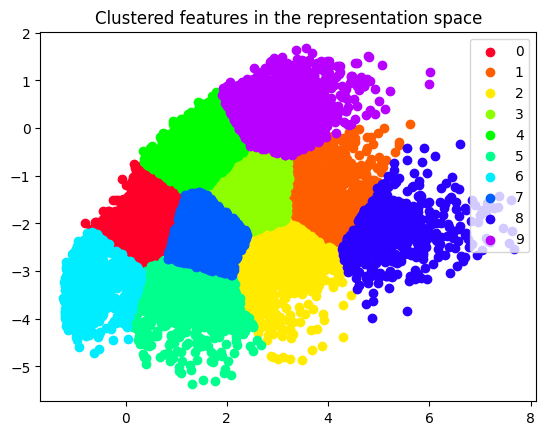

Accuracy of 0.390


In [8]:
def cluster_plot_data(representation, use_gmm=0, random_state=42, plot=1):
  from sklearn.cluster import KMeans
  from sklearn import mixture


  # Set number of clusters to 10
  n_clusters = 10
  if use_gmm:
    c_pred = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=random_state).fit_predict(representation)
  else:
    c_pred = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(representation)
  if plot:
    _, ax = plt.subplots(1,1)
    # Color map, and give different colors to every label
    cm = plt.get_cmap('gist_rainbow')
    ax.set_prop_cycle(color=[cm(1.*i/(n_clusters)) for i in range(n_clusters)])
    # Loop is to plot different color for each label
    for c in range(n_clusters):
      # Only select indices for corresponding label
      ind = c_pred == c
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(c))
    ax.legend()
    plt.title('Clustered features in the representation space')
    plt.show()
  return c_pred

c_pred = cluster_plot_data(representation)

# Compute accuracy by checking cluster by cluster the majority class and
# assigning all of the data points in that cluster to the majority class
# Then we check the accuracy of doing so
correct = 0
for i in range(10):
  indices_c_pred = c_pred == i
  classes = y_test[indices_c_pred]
  counts = np.bincount(classes)
  class_max = np.argmax(counts)
  correct += (classes == class_max).sum()

print('Accuracy of {:.3f}'.format(correct/(1.0*y_test.shape[0])))

Even though it is not a good way to classify the samples compared to the supervised case that you have done in past tutorials, the accuracy is still quite higher than random guess, which would be around ~10%. An autoencoder of higher capacity (e.g. using more layers, including activation functions or increasing the size of the representation layer) would likely produce representations with better accuracy using this clustering method.

## Relationship to PCA

When introducing autoencoders, it is usually mentioned that a linear autoencoder is closely related to PCA, i.e. using an autoencoder with representation dimensionality of $d$ is equivalent to finding the first $d$ principal components. Let's test it by computing the PCA of the train set, and applying it to the test set. Then we will check the representation space plot, and the reconstruction MSE and check if they are consistent with what we obtained with the simple linear autoencoder we just trained.

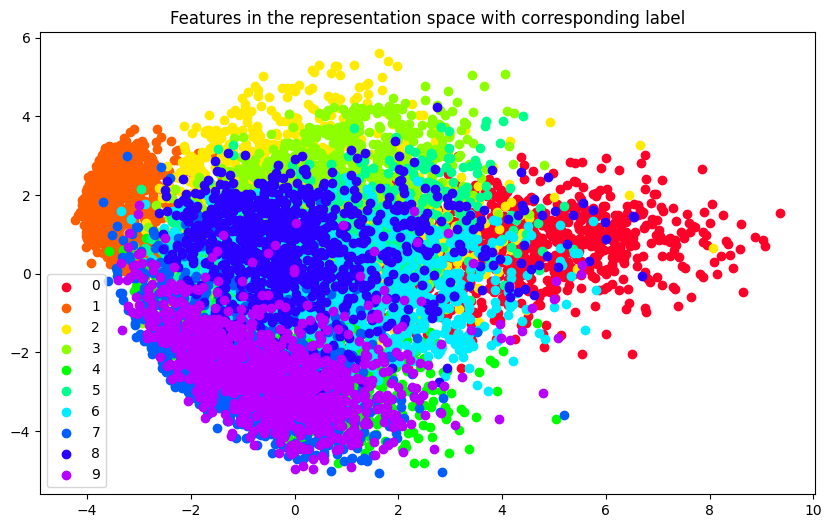

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(x_train)
representation_pca = pca.transform(x_test)
plot_representation_label(representation_pca, y_test)
plt.show()

We can see that the distribution of the PCA representations (size and shape of the clusters, and relative positions to the rest of clusters) is similar to the one obtained in the linear autoencoder section.

We now check if the MSE in the test set is similar to the linear autoencoder we trained before.

In [10]:
reconst_test = pca.inverse_transform(representation_pca)
mse_pca = ((reconst_test - x_test)**2).mean()

print('Test MSE for PCA is {:.4f}'.format(mse_pca))

Test MSE for PCA is 0.0557


The reconstruction error we get is almost the same as the one obtained with the autoencoder case, which seems to validate the claim that a linear autoencoder behaves in a similar way to PCA.

## Detecting Anomalies

After checking the representation of the MNIST images, let's focus on how to spot anomalies in the data. The anomalies are the samples that deviate from the usual distribution. Given a data point from a distribution 'B', the reconstruction error will be higher when using an autoencoder that was trained in a distribution 'A'. Anomaly detection has several uses, for example it can be used for quality control or to detect bank fraud.

We now will use that fact to detect anomalies. To do so, we will use the Extended MNIST (EMNIST) dataset, which, apart from digits, includes also both lowercase and uppercase characters from 'a' to 'z'. These 'a' to 'z' characters will act as the anomalies that we aim to detect. As our autoencoder was trained only using 0-9 digits, it should have higher reconstruction errors for those lowercase and uppercase characters, which will help us detect them as anomalies.

Let's start by downloading and loading the dataset. The following piece of code downloads the data and uncompresses some necessary files.

In [11]:
!wget https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip -q
!unzip -qq ./gzip.zip
!mv gzip data
# We need to unzip a couple of files with the train
# labels and images
!gunzip ./data/emnist-byclass-test-images-idx3-ubyte.gz
!gunzip ./data/emnist-byclass-test-labels-idx1-ubyte.gz
# We also install a package to help us
!pip install python-mnist

Now that we have downloaded the data, we will use the module `mnist` to load the images in the same format as the regular MNIST dataset included in Keras.

In [12]:
from mnist import MNIST

# Images in folder data
mndata = MNIST('data')

# This will load the test data from the downloaded files
emnist_x_test, emnist_y_test = mndata.load('./data/emnist-byclass-test-images-idx3-ubyte',
                               './data/emnist-byclass-test-labels-idx1-ubyte')


# Convert data to numpy arrays and normalize images to the interval [0, 1]
n_elem = len(emnist_x_test)
emnist_x_test = np.array(emnist_x_test).reshape(n_elem,28,28).transpose(0,2,1).reshape(n_elem,28**2) / 255.0
emnist_y_test = np.array(emnist_y_test)

# Get labels mapping (index in emnist_y_test to character value)
emnist_labels = map(lambda x: x.strip('\r').split(' '), open('./data/emnist-byclass-mapping.txt').read().strip().split('\n'))
emnist_labels = dict(emnist_labels)

# This function will be useful to display the actual label, which is given as
# an ascii value (https://en.wikipedia.org/wiki/ASCII) instead of characters
def label_to_char(label):
  ascii_val = emnist_labels[str(label)]
  return chr(int(ascii_val))

Here we just plot a random image from the EMNIST dataset. Each time you run it, you get a random image from the dataset, in case you want to check how the different characters look.

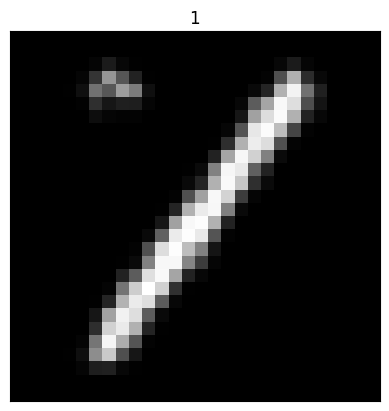

In [20]:
ind_plot = np.random.randint(emnist_x_test.shape[0]-1)
_, ax = plt.subplots(1,1)
plt.imshow(emnist_x_test[ind_plot].reshape(28, 28), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
# We use the label_to_char function to plot the actual character in the
# figure title
plt.title(label_to_char(emnist_y_test[ind_plot]))
plt.show()

Now we have loaded the EMNIST dataset. The images contain characters that the autoencoder has not seen before, hence the reconstruction error (we use Mean Squared Error as the reconstruction metric) for the EMNIST dataset should be higher. We will first compute the reconstruction error for both the MNIST test data and the EMNIST data. Then, we compare the distribution of reconstruction error in both sets using a histogram visualization.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


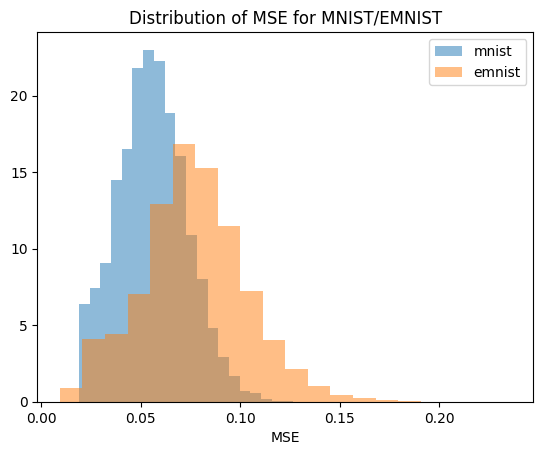

In [21]:
def compute_errors(model, mnist_data, emnist_data):
  ## This function plots the histogram of mse for a given model and two
  ## datasets (assuming mnist and emnist in this case)
  ## The function also returns the mse per sample for both datasets and the
  ## reconstructed images for both datasets

  # Predict reconstructed images for mnist
  reconst_mnist = model.predict(mnist_data)
  # Reshape and compute mse per image
  reconst_mnist = reconst_mnist.reshape(reconst_mnist.shape[0], -1)
  mnist_data = mnist_data.reshape(mnist_data.shape[0], -1)
  mse_mnist = ((reconst_mnist - mnist_data)**2).mean(-1)
  # Plot histogram, with density=True we normalize so the area adds up to 1
  plt.hist(mse_mnist, bins=20, label='mnist', alpha=0.5, density=True)

  # Same for EMNIST, first predict reconstructed images
  reconst_emnist = model.predict(emnist_data)
  # Reshape and compute mse per image
  reconst_emnist = reconst_emnist.reshape(reconst_emnist.shape[0], -1)
  emnist_data = emnist_data.reshape(emnist_data.shape[0], -1)
  mse_emnist = ((reconst_emnist - emnist_data)**2).mean(-1)
  # Plot histogram
  plt.hist(mse_emnist, bins=20, label='emnist', alpha=0.5, density=True)
  # Title, label and legend
  plt.xlabel('MSE')
  plt.title('Distribution of MSE for MNIST/EMNIST')
  plt.legend()
  plt.show()
  return reconst_mnist, mse_mnist, reconst_emnist, mse_emnist

reconst_mnist, mse_mnist, reconst_emnist, mse_emnist = compute_errors(model,
                                                                      x_test,
                                                                      emnist_x_test)

As we expected, the distribution of errors for the EMNIST dataset has a higher mean and variance compared to the original MNIST. Let's now check how the image with the lowest reconstruction error and the image with the highest reconstruction error look.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


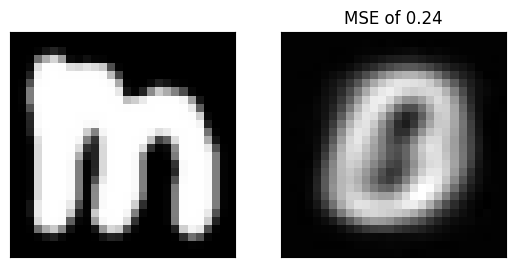

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


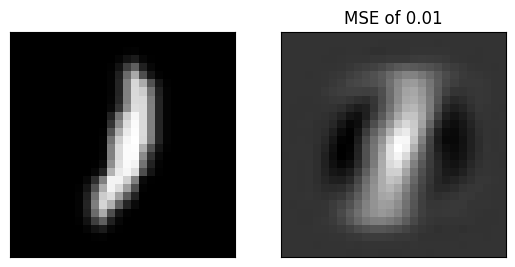

In [22]:
plot_recons_original(emnist_x_test[mse_emnist.argmax()], emnist_y_test[mse_emnist.argmax()], model)
plot_recons_original(emnist_x_test[mse_emnist.argmin()], emnist_y_test[mse_emnist.argmin()], model)

It seems that the model is not capable of representing images from the EMNIST dataset that deviate too much from those in the MNIST dataset, as for example images representing the letter 'm'. However, the autoencoder behaves well for images that are similar to those from MNIST, which is what we expected.

We now perform an anomaly detection exercise. We set the threshold $\tau$, which we use to mark a data point as an anomaly if $||x-\psi(\phi(x))||^2>\tau$, as $\tau = \mu + 2\sigma$, where $\mu$ is the average MSE for the whole MNIST test set, and $\sigma$ is the standard deviation of the MSE in the MNIST test set. We will now plot the ratio of data points marked as anomalies for each of the classes in both MNIST and EMNIST. Additionally, we also report the average MSE per class in both datasets. We expect to see that the number of MNIST anomalies is quite lower compared to the number of anomalies in the EMNIST dataset, as our autoencoder has been trained with MNIST data.

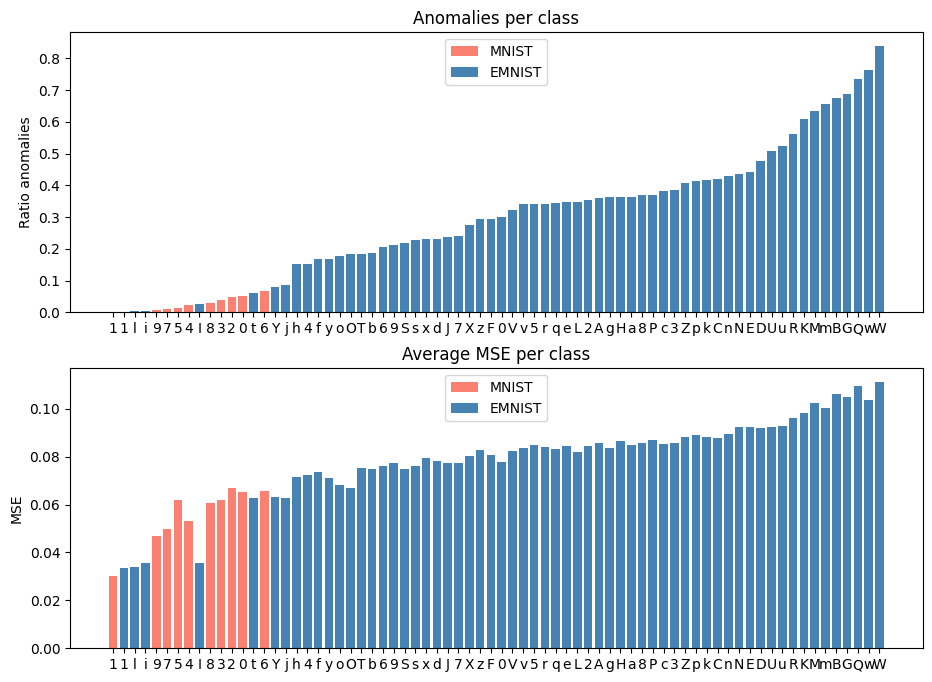

In [23]:
def print_mse_anomalies(mse_mnist, mse_emnist, emnist_labels, th=-1):
  ## This function uses the mse per class in both MNIST and EMNIST
  ## to compute the ratio of anomalies per class (anomalies/examples per class)
  ## We plot anomalies and mse in a bar histogram, ordered by ratio of anomalies
  ## Do not worry too much about how it works.

  # If no threshold (\tau) is given, we set it to \mu + 2\sigma
  if th == -1:
    th = 2*mse_mnist.std() + mse_mnist.mean()
  # MNIST labels are from 0-9
  mnist_labels = range(10)

  # Initialize a list where we will save the
  save_array = []

  # We start with MNIST
  for label in mnist_labels:
    # Indices with class == label
    indices_class = y_test == int(label)
    # Ratio of anomalies
    ratio_anom = (mse_mnist[indices_class] > th).sum()/(1.0*indices_class.sum())
    # Form an array with the mean mse in the class, the ratio of anomalies,
    # the corresponding label and a color which will use to plot this
    save_array.append([mse_mnist[indices_class].mean(),
                       ratio_anom, str(label), 'salmon'])
  # Next is EMNIST
  for label in emnist_labels:
    indices_class = emnist_y_test == int(label)
    ratio_anom = (mse_emnist[indices_class] > th).sum()/(1.0*indices_class.sum())
    save_array.append([mse_emnist[indices_class].mean(),
                       ratio_anom, label_to_char(label), 'steelblue'])

  # Number of total classes
  n_classes = len(save_array)
  # We have a list of lists in distance_classes, we want to sort it by the
  # ratio of anomalies, which is the index 1. To do so, we use sorted with
  # key=lambda x: x[1]
  save_array = sorted(save_array, key=lambda x: x[1])

  # Retrieve mse, anomalies, labels names and colors to plot from save_array
  mse_class = list(map(lambda x: x[0], save_array))
  anomalies_class = list(map(lambda x: x[1], save_array))
  labels_names = list(map(lambda x: x[2], save_array))
  colors = list(map(lambda x: x[3], save_array))

  # Plotting stuff
  plt.subplots(2,1, figsize=(11,8))
  plt.subplot(2,1,1)
  bars = plt.bar(range(n_classes), anomalies_class, color=colors)
  plt.xticks(range(n_classes), labels_names)
  plt.legend([bars[0],bars[-1]], ['MNIST', 'EMNIST'], loc='upper center')
  plt.title('Anomalies per class')
  plt.ylabel('Ratio anomalies')
  plt.subplot(2,1,2)
  plt.bar(range(n_classes), mse_class, color=colors)
  plt.xticks(range(n_classes), labels_names)
  plt.legend([bars[0],bars[-1]], ['MNIST', 'EMNIST'], loc='upper center')
  plt.title('Average MSE per class')
  plt.ylabel('MSE')
  plt.show()
print_mse_anomalies(mse_mnist, mse_emnist, emnist_labels)

The top figure shows the ratio of anomalies per class, which is the number of anomalies detected for the data points of that class divided by the number of examples of that specific class. The bottom figure shows the average error per category, where we can see that the classes from EMNIST have a higher reconstruction error than those from MNIST. The shared classes in MNIST and EMNIST, the digits 0-9, seem to have a different distribution in those two datasets as the reconstruction error for those classes in EMNIST is higher than in MNIST. Additionally, some letters that look like the number 1 (`l, I, i, t, j`) or like 0 (`O` and `o`) have a low reconstruction error as they are similar to some of the images in the MNIST dataset. Some other classes, such as `W`, `w`, or `Q` have a high reconstruction error due to being quite dissimilar to any of the images in MNIST.

We have seen that data from other datasets will have a high reconstruction error. However, even for MNIST, we can look for samples that have a high reconstruction error compared to the average. We expect to see that most images in a given class will follow a similar distribution, however some of them will deviate from this distribution.

In that direction, let's take one of the classes from MNIST and plot some images with high reconstruction error and some others with low reconstruction error. We expect to see those with low reconstruction error to be quite similar between them and represent what the average sample of that class looks like. The high reconstruction error samples will, in turn, contain some elements (pose, shape for example).


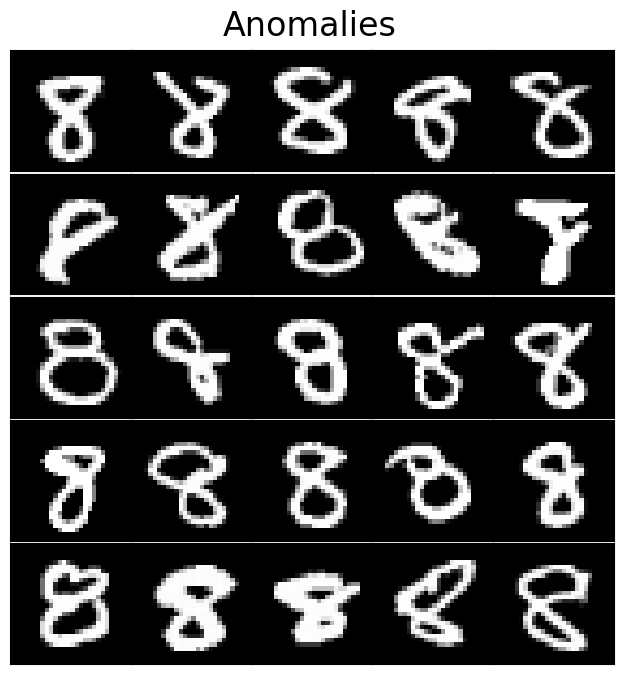

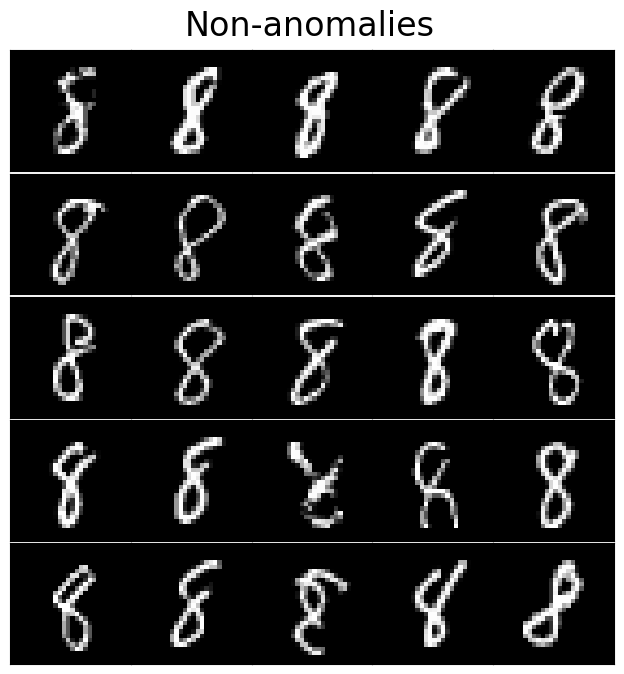

In [24]:
# Set same threshold we defined before \mu + 2\sigma
th = mse_mnist.std() + mse_mnist.mean()

# We will use the label 8 for the example
indices_class = y_test == 8

# Compute the number of anomalies (mse > th)
anomalies_im = x_test[indices_class][mse_mnist[indices_class] > th]

# For the nonanomalies, we will sort the images by reconstruction error
# So we will plot the images with low reconstruction error
indices_sort = np.argsort(mse_mnist[indices_class])
nonanomalies_im = x_test[indices_class][indices_sort]

def plot_grid(images, N=5, title=''):
  ## Plots data in variable images in a grid of N*N
  # Create figure
  fig, axes = plt.subplots(N,N, figsize=(8,8))
  # Loop to generate grid
  for row in range(N):
    for col in range(N):
      idx = row+N*col
      axes[row,col].imshow(images[idx].reshape(28,28), cmap='gray')
      axes[row,col].set_xticks([])
      axes[row,col].set_yticks([])

  # Adjust white space
  fig.subplots_adjust(hspace=0.0)
  fig.subplots_adjust(wspace=0.0)
  fig.subplots_adjust(right=1.0)
  fig.subplots_adjust(left=0.245)
  # Set title
  fig.suptitle(title, x=0.62, y=0.93, fontsize=24)

# Plot anomalies
plot_grid(anomalies_im, title='Anomalies')
# Plot non-anomalies
plot_grid(nonanomalies_im, title='Non-anomalies')

The images classified as anomalies for the given threshold $\tau$ show a much larger variation in shape and pose. In turn, the images with low reconstruction error for the selected label (in this case `8`) show similar proportions and less variation between any two images.

# Image-to-Image Translation

As seen previously, autoencoders aim at creating low-dimensionality representations that only preserve the most discriminative information of the input signals. We can train them by looking into the reconstruction error between the input and the generated data. This training process is a form of *self-supervision* learning. Thus, the encoding part is trained to create a strong feature representation, from which the decoder can reconstruct the original data.

The dimensionality reduction/compression is widely used in many signal processing tasks. However, autoencoders are also applied in many image-to-image tasks. Here we will show how to train an autoencoder as a denoising method.

## Denoising with Autoencoders

The idea behind this task is that autoencoders will preserve only the characteristic information and avoid noise on the reconstruction.

Noise is random, and it can not be predicted. Therefore, a robust encoding/decoding learns to identify the stable patterns within the image, and avoid the non-smooth perturbations produced by the noise.

This idea is in line with the **Efficient Coding Hypothesis** from the vision neuroscience field, which says ". . . the Efficient Coding Hypothesis holds that the purpose of early visual processing is to produce an efficient representation of the incoming visual signal."

Noise can be presented in many different ways in images. In this tutorial, we will generate synthetically additive Gaussian noise to train our denoising autoencoder.

In [25]:
# Load the data, shuffled and split between train and test sets
(x_train, _), (x_test, _) = datasets.cifar100.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.3)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.3)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


We can visualise some examples to have an idea of how the noise looks like:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


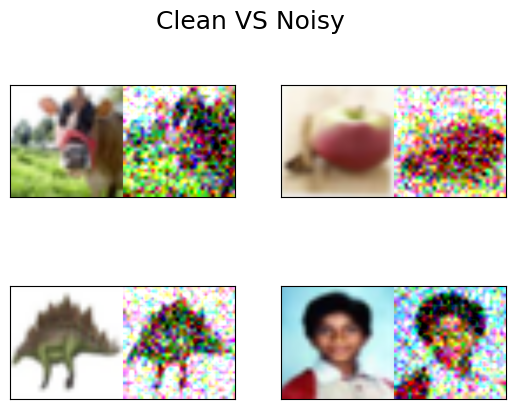

In [26]:
# Resize images for better visualization
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Resizing(224, 224),
])

x_train_resized = model.predict(x_train[:4, ...])
x_train_noise_resized = model.predict(x_train_noise[:4, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Clean VS Noisy', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col

    im = np.concatenate((x_train_resized[idx], x_train_noise_resized[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

### Linear Autoencoders

As in regular architecture design, when defining the structure of an autoencoder, we can decide the number of convolutional layers, dense layers, normalisation mechanisms, activation functions, and so on.

Similar to the Representation Learning section, in this denoising task, we start with a linear architecture.

In [27]:
model = models.Sequential([
    #Encoder
    layers.Input(shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(30),

    #Decoder
    layers.Dense(128),
    layers.Dense(32*32*3),
    layers.Reshape((32, 32, 3))
])

We train our model with the standard Mean Square Error (MSE) loss function. We compute MSE between reconstructed images and noisy ones. Ideally, as mentioned above, the noise is random, and therefore, it will not be modelled.

Sometimes we have a dataset that contains noisy and clean images. If that is the case, we could compute the MSE between the reconstructed and the clean ones. Using clean ground-truth images (*supervised learning*) improves results compared to only using noisy ones (*self-supervised learning*). However, we want to start from the perspective of image compression and feature representation, and train our denoising model using exclusively noisy images.

In [28]:
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1755 - mse: 0.1755 - val_loss: 0.1112 - val_mse: 0.1112
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1093 - mse: 0.1093 - val_loss: 0.1062 - val_mse: 0.1062
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1055 - mse: 0.1055 - val_loss: 0.1045 - val_mse: 0.1045
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.1036 - val_mse: 0.1036
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1035 - mse: 0.1035 - val_loss: 0.1036 - val_mse: 0.1036
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1030 - mse: 0.1030 - val_loss: 0.1035 - val_mse: 0.1035
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1238 - mse: 0.1238 - val_loss: 0.1047 - val_mse: 0.1047
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1043 - mse: 0.1043 - val_loss: 0.1038 - val_mse: 0.1038
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

Let's check how denoised images look like after ten epochs of training. Run the following code multiple times to see different examples:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


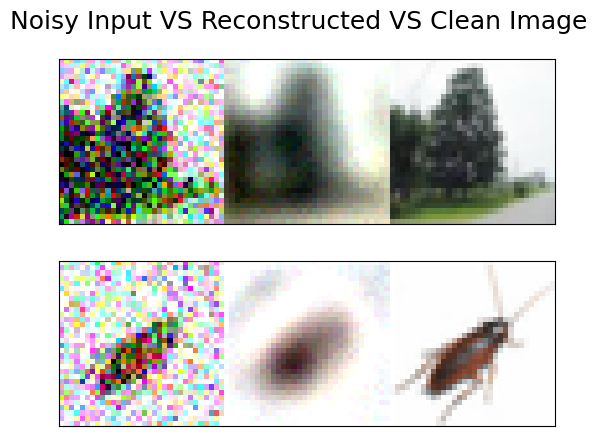

In [29]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Reconstructed images are a much-blurred version of the clean ones. The proposed autoencoder can learn to remove noise, but results are far from being perfect when comparing them with the ground-truth images. Note though that with a few neurons, the network can generate images that have roughly the same colour and shape than the original ones.

### Non-linear Autoencoders

In non-linear autoencoders, we introduce non-linearities within the network by using non-linear activation functions. This is a big difference with classical technique PCA, which performs a linear transformation of the data. Thus, using non-linear autoencoders allows us to create flexible algorithms that can learn relationships in the data beyond linear transformations.

In [34]:
nonlinear_model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Encoder
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(30),

    # Decoder
    layers.Dense(128),
    layers.Dense(32*32*3, activation='sigmoid'),
    layers.Reshape((32, 32, 3))
])

nonlinear_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
nonlinear_model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1364 - mse: 0.1364 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1061 - mse: 0.1061 - val_loss: 0.1039 - val_mse: 0.1039
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1036 - mse: 0.1036 - val_loss: 0.1032 - val_mse: 0.1032
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1028 - mse: 0.1028 - val_loss: 0.1030 - val_mse: 0.1030
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1027 - mse: 0.1027 - val_loss: 0.1028 - val_mse: 0.1028
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.1028 - val_mse: 0.1028
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.1027 - val_mse: 0.1027
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

We can now visualise the reconstructed images by the proposed non-linear model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


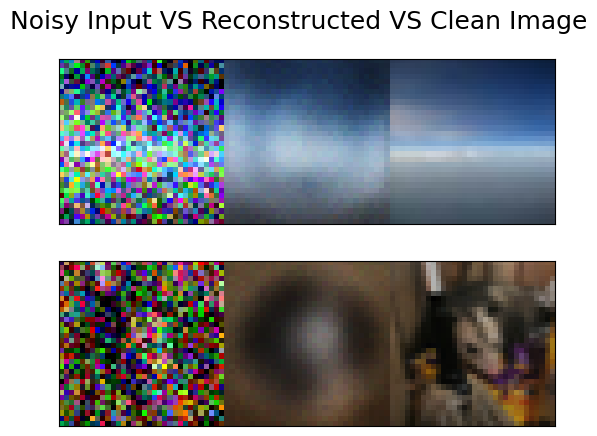

In [35]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = nonlinear_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Qualitatively results at this stage are difficult to interpret. Hence, we compute the MSE metric in the test set for both architectures and compare them:

In [36]:
mse_linear, _ = model.evaluate(x_test_noise, x_test)
mse_nonlinear, _ = nonlinear_model.evaluate(x_test_noise, x_test)

print('MSE Linear Model: {:0.3f}'.format(mse_linear))
print('MSE Non-linear Model: {:0.3f}'.format(mse_nonlinear))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - mse: 0.0150
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - mse: 0.0145
MSE Linear Model: 0.015
MSE Non-linear Model: 0.015


Although results are close, we can observe an improvement in MSE just by applying a non-linear activation function to the network.

### Convolutional Autoencoders

As seen in previous tutorials, 2D convolutions are more suitable when the input is an image than 1D convolutions. In practical settings, convolutional autoencoders are always applied to images, they simply perform much better.

CNNs are used exactly as before, however, now we have to take into account elements such as strides, pooling, upsampling, and deconvolutions. Those elements are needed to control the size (width and length) of the generated feature maps. A regular setting in image denoising is that the input and output dimension is constant.

Besides, we need to define the number of levels of compression within the architecture, which can be controlled by limiting the number of convolutional layers and/or downsampling steps:


![](https://i.ibb.co/vB2jq4C/autoencoders.png)

Let's define and train an architecture with 3 compression levels:



In [37]:
CNN_model = models.Sequential()

## Encoder starts
CNN_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# At this point the dimension of the feature map is (batch_size, 4, 4, 128)

## And now the decoder
CNN_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(layers.UpSampling2D((2, 2)))
CNN_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(layers.UpSampling2D((2, 2)))
CNN_model.add(layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(layers.UpSampling2D((2, 2)))

# Improve smoothness of the image:
CNN_model.add(layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))

CNN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
CNN_model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.1491 - mse: 0.1491 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1013 - mse: 0.1013 - val_loss: 0.0978 - val_mse: 0.0978
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0958 - mse: 0.0958 - val_loss: 0.0942 - val_mse: 0.0942
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0936 - mse: 0.0936 - val_loss: 0.0917 - val_mse: 0.0917
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0921 - mse: 0.0921 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0910 - mse: 0.0910 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0899 - mse: 0.0899 - val_loss: 0.0889 - val_mse: 0.0889
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0891 - mse: 0.0891 - val_loss: 0.0885 - val_mse: 0.0885
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - 

In our example, our encoder uses strides of (2, 2) in the convolutions. (2, 2) stride downsamples the dimension of the feature map by two at every step. To recover the original size, in the decoder, we use UpSampling2D layers. (2, 2) UpSampling2D layers increase by two the dimensionality of the input feature map. These two mechanisms allow us to control the dimensions of the feature maps throughout the autoencoder.

Let's check how the reconstructed images look:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


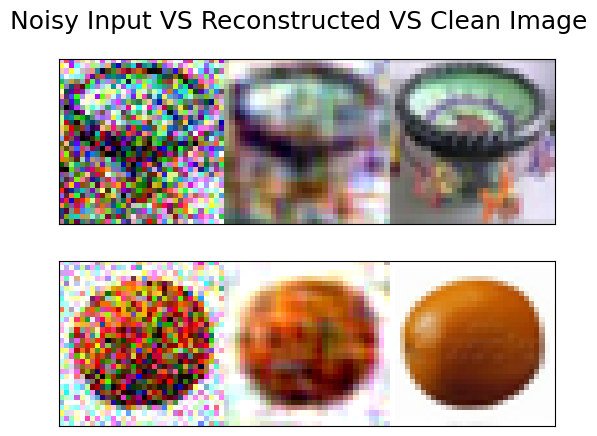

In [38]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = CNN_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

And check their MSE error:

In [39]:
mse_linear, _ = model.evaluate(x_test_noise, x_test)
mse_nonlinear, _ = nonlinear_model.evaluate(x_test_noise, x_test)
mse_cnn, _ = CNN_model.evaluate(x_test_noise, x_test)

print('MSE Linear Model: {:0.3f}'.format(mse_linear))
print('MSE Non-linear Model: {:0.3f}'.format(mse_nonlinear))
print('MSE CNN Model: {:0.3f}'.format(mse_cnn))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - mse: 0.0150
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - mse: 0.0145
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0121 - mse: 0.0121
MSE Linear Model: 0.015
MSE Non-linear Model: 0.015
MSE CNN Model: 0.012


We are getting better at it!

### Denoising with Clean Images

We showed that autoencoders can encode the image's structure and recover a clean but blurry image. They ignore the non-smooth perturbations produced by the noise, allowing us to train them in a self-supervised setting.

Although having a ground-truth of clean images is not always possible, it is desirable when training denoising models. As we have generated synthetically the noise, we can train the network using the original image as the clean one:

In [40]:
CNN_gt_model = models.Sequential()

## Encoder starts
CNN_gt_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_gt_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_gt_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# At this point the dimension of the feature map is (batch_size, 4, 4, 128)

## And now the decoder
CNN_gt_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(layers.UpSampling2D((2, 2)))
CNN_gt_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(layers.UpSampling2D((2, 2)))
CNN_gt_model.add(layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(layers.UpSampling2D((2, 2)))

# Improve smoothness of the image:
CNN_gt_model.add(layers.Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))

CNN_gt_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
CNN_gt_model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - l

Let's now check how the reconstructed images look:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


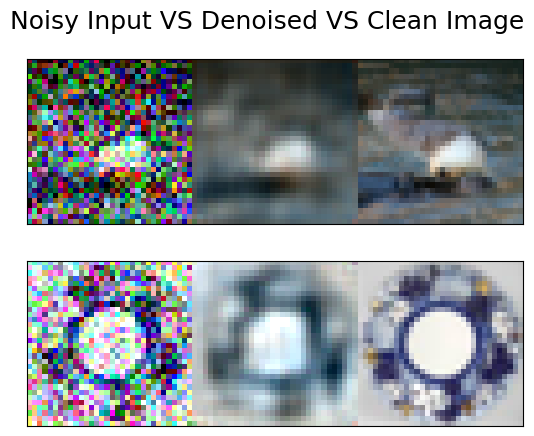

In [41]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = CNN_gt_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

In addition, we can compare the MSE when having clean images for training or not:

In [42]:
mse_selfsupervised, _ = CNN_model.evaluate(x_test_noise, x_test)
mse_supervised, _ = CNN_gt_model.evaluate(x_test_noise, x_test)

print('MSE "Self"-supervised Model. Trained only with Noisy Images: {:0.3f}'.format(mse_selfsupervised))
print('MSE Supervised Model. Trained also with Clean Images: {:0.3f}'.format(mse_supervised))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - mse: 0.0121
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - mse: 0.0089
MSE "Self"-supervised Model. Trained only with Noisy Images: 0.012
MSE Supervised Model. Trained also with Clean Images: 0.009


Even though there is a clear improvement, at this point, the results do not differ that much. Thus, having clean images is not enough for denoising images. We could try to increase the model's complexity, however, we propose to use now skip connections.

### Skip Connections

Skip connections in Autoencoders were introduced in the *Common CNN Architectures* tutorial, together with [UNet](https://arxiv.org/pdf/1505.04597.pdf) network. Skip connections, as the name suggests, creates connections between layers within the neural network by jumping some of them. This connection allows the network to feed layers not only with the previous one but, in addition, with other layers that were not directly connected. For example, in the next figure we can see an architecture, where  the encoder and decoder share features through skip connections:

![texto alternativo](https://i.ibb.co/d7sX5bh/Skip-Connections.png)

The idea behind this is that there is information in the first layers that is hard to recover by posterior ones. This information is important when upsampling the feature map in the decoder, where instead of learning how to recover features from the first layers, it can learn how to directly used them to generate better outputs.

Besides, skip connections help to pass information through the network, helping to mitigate the vanishing gradient problem when the architecture is deep. As seen in the *Common CNN Architectures* tutorial, gradient information can be lost during the backpropagation when it goes through many layers. Having a direct path between encoder and decoder layers helps the convergence and training of the network.

There are many ways to implement those skip connections, we show in the next example how to generate them by concatenating features:

In [43]:
def define_skip_model():

  input_net = layers.Input((32,32,3))

  ## Encoder starts
  conv1 = layers.Conv2D(32, 3, strides=(2,2), activation = 'relu', padding = 'same')(input_net)
  conv2 = layers.Conv2D(64, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv1)
  conv3 = layers.Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv2)

  conv4 = layers.Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv3)

  ## And now the decoder
  up1 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(layers.UpSampling2D(size = (2,2))(conv4))
  merge1 = layers.concatenate([conv3,up1], axis = 3)
  up2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(layers.UpSampling2D(size = (2,2))(merge1))
  merge2 = layers.concatenate([conv2,up2], axis = 3)
  up3 = layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(layers.UpSampling2D(size = (2,2))(merge2))
  merge3 = layers.concatenate([conv1,up3], axis = 3)

  up4 = layers.Conv2D(32, 3, padding = 'same')(layers.UpSampling2D(size = (2,2))(merge3))

  output_net = layers.Conv2D(3, 3, padding = 'same')(up4)

  model = models.Model(inputs = input_net, outputs = output_net)

  return model

Let's train the model skip connections:

In [44]:
skip_model = define_skip_model()
skip_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
skip_model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = skip_model.evaluate(x_test_noise, x_test)
print('MSE Model without Skip Connections: {:0.3f}'.format(mse_supervised))
print('MSE Model with Skip Connections: {:0.3f}'.format(mse))

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms

Let's visualise how the denoised images look:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


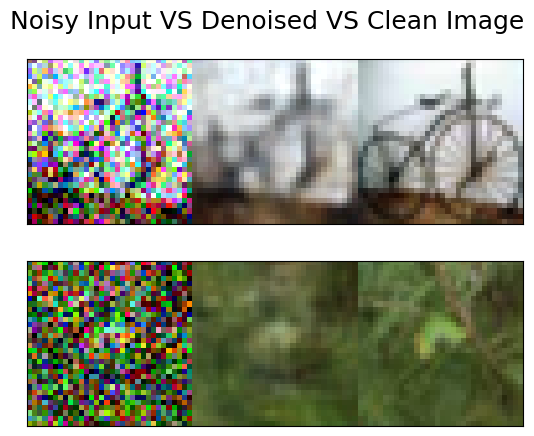

In [45]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = skip_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Images are a bit blurry, but noise is almost all gone!

## Image Segmentation with Autoencoders

Autoencoders have been used for multiple tasks, their applications do not limit to representation learning, or image denoising. We are going to show here how to use them to do a more general task, image segmentation.

Image segmentation is the task of assigning a class value to each pixel in the input image. To do so, we have prepared the [COCO-Person](https://www.kaggle.com/oishee30/cocopersonsegmentation) dataset. COCO-Person dataset contains a collection of images and their respective masks. Their masks indicate if a pixel is background or person. Let's first of all download it:

In [46]:
# download the Supervise.ly Filtered Segmentation Person Dataset
!wget -q https://imperialcollegelondon.box.com/shared/static/kq70816mxj4mnfph5kxt352xnx40rzeq.zip
!unzip -qq kq70816mxj4mnfph5kxt352xnx40rzeq.zip

print('Dataset downloaded')

def load_split(split):
    images = os.listdir('is_coco_dataset/'+ split + '/')
    data, labels = [], []
    for i in images:
        data += [cv2.imread('is_coco_dataset/'+ split + '/' + i)]
        label = cv2.cvtColor(cv2.imread('is_coco_dataset/masks/' + i), cv2.COLOR_BGR2GRAY)
        labels += [np.where(label > 100, 1, 0)]

    return np.asarray(data), np.asarray(labels)

def load_data():
    print('Start loading data')
    train_data, train_labels = load_split('train')
    val_data, val_labels = load_split('val')
    test_data, test_labels = load_split('test')

    return [train_data, train_labels], [val_data, val_labels], [test_data, test_labels]


def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_val /= 255.
x_test /= 255.

x_train, y_train, x_val, y_val = shuffle_data(x_train, y_train, x_val, y_val)

# person vs background
num_classes = 2
y_train = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

Dataset downloaded
Start loading data


We now can visualise the dataset. We plot the input images, segmented masks, and their overlapping. Run it multiple times for different examples:

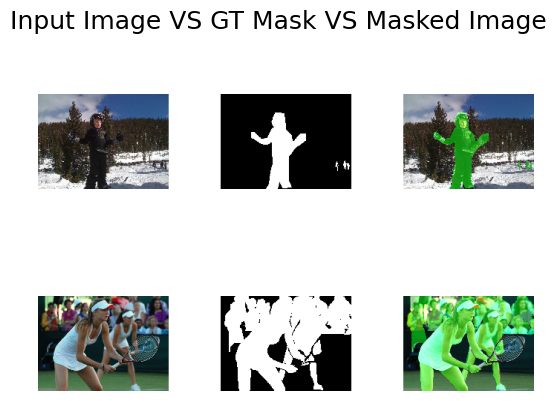

In [47]:
N = 2
y_train_vis = np.where(y_train[:, :, :, 1] >= 0.5, 1., 0.).astype(np.float32)
y_train_mask = np.tile(y_train_vis[:, :, :, np.newaxis], [1, 1, 1, 3])
y_train_vis_gt = np.zeros((len(y_train), 128, 176, 3), np.float32)
y_train_vis_gt[:, :, :, 1] = y_train_vis
blank_space = np.ones((128, 70, 3), np.float32)

start_val = np.random.randint(len(y_train)-N**2)
fig, axes = plt.subplots(N, 1)
plt.suptitle('Input Image VS GT Mask VS Masked Image', fontsize=18)
for row in range(N):
    for col in range(1):
        idx = start_val + row + N * col

        overlap_gt = cv2.addWeighted(x_train[idx], 1, y_train_vis_gt[idx], 0.5, 0)

        im = np.concatenate((x_train[idx], blank_space, y_train_mask[idx], blank_space, overlap_gt), 1)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        axes[row].imshow(np.clip(im, 0, 1))
        axes[row].axis("off")

Segmenting the background of a portrait photo is a really popular task in daily applications. For instance, if you do not have a DSLR camera, you still can get those blurry backgrounds thanks to Autoencoders. Applications do not end there, check some examples of what you can do in the [Google AI Blog](https://ai.googleblog.com/2018/03/mobile-real-time-video-segmentation.html). Here there is one example from them:


<a href="https://ibb.co/0hhQ3Zt"><img src="https://3.bp.blogspot.com/-jp16CE_SLZk/WpW1sKWU9PI/AAAAAAAACY0/sjHghHiuarEC2aEy5txhmdT6INK9C_OxACLcBGAs/s640/image3.gif" alt="Screenshot-from-2019-02-14-14-49-24" border="0"></a>


Now that we have the data and understand the task, we can define a model and train it:

In [48]:
def autoencoder_model():

  input_net = layers.Input((128, 176, 3))

  ## Encoder starts
  conv1 = layers.Conv2D(32, 3, strides=(2,2), activation = 'relu', padding = 'same')(input_net)
  conv2 = layers.Conv2D(64, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv1)
  conv3 = layers.Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv2)

  conv4 = layers.Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv3)

  ## And now the decoder
  up1 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(layers.UpSampling2D(size = (2,2))(conv4))
  merge1 = layers.concatenate([conv3,up1], axis = 3)
  up2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(layers.UpSampling2D(size = (2,2))(merge1))
  merge2 = layers.concatenate([conv2,up2], axis = 3)
  up3 = layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(layers.UpSampling2D(size = (2,2))(merge2))
  merge3 = layers.concatenate([conv1,up3], axis = 3)

  up4 = layers.Conv2D(32, 3, padding = 'same')(layers.UpSampling2D(size = (2,2))(merge3))

  output_net = layers.Conv2D(2, 3, padding = 'same', activation='softmax')(up4)

  model = models.Model(inputs = input_net, outputs = output_net)

  return model

model = autoencoder_model()
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=30)

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - accuracy: 0.5431 - loss: 0.6665 - val_accuracy: 0.7529 - val_loss: 0.5538
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.7472 - loss: 0.5500 - val_accuracy: 0.7529 - val_loss: 0.4971
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.7480 - loss: 0.5018 - val_accuracy: 0.7619 - val_loss: 0.4770
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7521 - loss: 0.4935 - val_accuracy: 0.7603 - val_loss: 0.4865
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.7637 - loss: 0.4749 - val_accuracy: 0.7715 - val_loss: 0.4675
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.7691 - loss: 0.4692 - val_accuracy: 0.7741 - val_loss: 0.4586
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.7752 - loss: 0.4572 - val_accuracy: 0.7824 - val_loss: 0.4445
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.7764 - loss: 0.4547 - val_accuracy: 0

In addition to the previous code, we also provide code for visualising the predicted masks on the test set:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


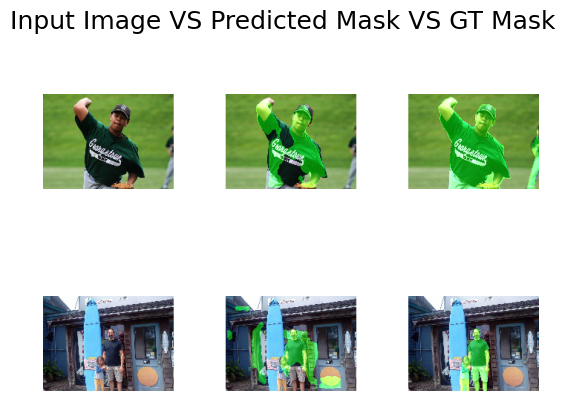

In [49]:
id_examples = np.random.permutation(range(0, len(x_test)-1))
x_test, y_test = x_test[id_examples], y_test[id_examples]
x_test_out = model.predict(x_test[:2, ...])

x_test_out = np.where(x_test_out[:, :, :, 1] >= 0.5, 1., 0.).astype(np.float32)
x_test_vis = np.zeros((2, 128, 176, 3), np.float32)
x_test_vis[:, :, :, 1] = x_test_out

y_test_vis = np.where(y_test[:2, :, :, 1] >= 0.5, 1., 0.).astype(np.float32)
y_test_vis_gt = np.zeros((2, 128, 176, 3), np.float32)
y_test_vis_gt[:, :, :, 1] = y_test_vis
blank_space = np.ones((128, 70, 3), np.float32)

N = 2
start_val = 0
fig, axes = plt.subplots(N, 1)
plt.suptitle('Input Image VS Predicted Mask VS GT Mask', fontsize=18)
for row in range(N):
    for col in range(1):
        idx = start_val + row + N * col

        overlap = cv2.addWeighted(x_test[idx], 1, x_test_vis[idx], 0.5, 0)
        overlap_gt = cv2.addWeighted(x_test[idx], 1, y_test_vis_gt[idx], 0.5, 0)

        im = np.concatenate((x_test[idx], blank_space, overlap, blank_space, overlap_gt), 1)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        axes[row].imshow(np.clip(im, 0, 1))
        axes[row].axis("off")

You could run your segmentation network on internet images and see how it performs there. You could even try to do the background blurring effect we introduced above!

# Coursework

## Task 1: Non-linear Transformations for Representation Learning

PCA is a standard dimensionality reduction technique that uses a linear transformation. In this task we are going to define two autoencoders, one convolutional and one without using any convolutional layer, that are capable of learning a non-linear transformation to reduce the dimensionality of the input MNIST image, and we will compare those autoencoders to PCA. A way to evaluate the quality of the representations produced by both PCA and the autoencoder is to learn a classifier on top of those representations with reduced dimensionality. If the classifier has high accuracy, then the representations can be considered meaningful. In our case, we will use representations with dimensionality 10 and we will use those representations to train a linear classifier, which is defined in the code below.

The given example architectures for both the non-convolutional and the convolutional autoencoder already produce, after training them, representations of similar quality as PCA. Modify the given architectures and try to increase the accuracy when training a linear classifier on top of the autoencoder representations. The code given below may help you understand the pipeline.

As in past notebooks, treat the MNIST test set as your validation set. You can use any of the layers and techniques presented in past notebooks, the only constraints are that the non-convolutional autoencoder should not have any Conv2d layer, that the convolutional autoencoder should include Conv2d layers, and that the representation vector should have dimensionality 10.

**Report**:
* Table with the accuracy of `classifier` (defined below) obtained with the representations from your two proposed  autoencoder architectures (non-convolutional and convolutional autoencoder) and also with PCA with 10 components in the training set and the validation set. Additionally, include in the table the MSE error in both training and validation set for your non-convolutional autoencoder, for your convolutional autoencoder and for the PCA method. State clearly your two final autoencoder architectures and discuss the results.

We will use MNIST for this task. First, we resize all the images to have a resolution of 32x32, which will make the definition of the convolutional autoencoder easier.

In [50]:
np.random.seed(123)  # for reproducibility

num_classes = 10

# Use x_test as your validation set
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train= x_train.astype('float32')
x_test= x_test.astype('float32')
x_train /= 255.
x_test /= 255.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_train_32 = np.zeros((x_train.shape[0], 32,32,1))
x_test_32 = np.zeros((x_test.shape[0], 32,32,1))
# We resize the images
for n in range(x_train.shape[0]):
    x_train_32[n,:,:,:] = resize(x_train[n,:,:,:], (32,32,1), anti_aliasing=True)
for n in range(x_test.shape[0]):
    x_test_32[n,:,:,:] = resize(x_test[n,:,:,:], (32,32,1), anti_aliasing=True)

You can modify the code below to define your autoencoder. You can use any layer you want apart from `Conv2D` layers for this autoencoder.

In [51]:
### Modify the model here
autoencoder = models.Sequential()
autoencoder.add(layers.Input((32,32,1)))
autoencoder.add(layers.Flatten())

# The representation has dimensionality 10, do not change the dimensionality
autoencoder.add(layers.Dense(10, name='representation'))
autoencoder.add(layers.Dense(32*32))
autoencoder.add(layers.Reshape((32,32,1)))
autoencoder.summary()

autoencoder.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 20
history = autoencoder.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ representation (Dense)               │ (None, 10)                  │          10,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1024)                │          11,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 32, 32, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,514 (84.04 KB)

 Trainable params: 21,514 (84.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

You can modify the code below to define your convolutional autoencoder. For this autoencoder you need to include `Conv2D` layers in your design, but you can use any other layer too. We show an example of a simple convolutional architecture below

In [52]:
### Modify the model here
### This is an example of a simple/bad convolutional autoencoder
conv_autoencoder = models.Sequential()
conv_autoencoder.add(layers.Conv2D(32, 3, strides=2, padding='same'))
conv_autoencoder.add(layers.Flatten())
# The representation has dimensionality 10, do not change the dimensionality
conv_autoencoder.add(layers.Dense(10, name='representation'))
conv_autoencoder.add(layers.Dense(1*16*16))
conv_autoencoder.add(layers.Reshape((16,16,1)))
conv_autoencoder.add(layers.UpSampling2D((2, 2)))

conv_autoencoder.build((None,32,32,1))
conv_autoencoder.summary()

conv_autoencoder.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 20
history = conv_autoencoder.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32))

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ representation (Dense)               │ (None, 10)                  │          81,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 32, 32, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,066 (332.29 KB)

 Trainable params: 85,066 (332.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

Below you have the code you will use to train the classifier. We first extract the representations using any of the two autoencoders we just trained or PCA and then we train the classifier on top, which is just a simple Dense layer. Better representations should make it easier for the given simple classifier to separate the classes and, therefore, have larger accuracy.

In [53]:
pca = PCA(n_components=10)
pca = pca.fit(x_train_32.reshape(x_train_32.shape[0], -1))

## We compute the representations for the different methods
representation_pca_train = pca.transform(x_train_32.reshape(x_train_32.shape[0], -1))
representation_pca_test = pca.transform(x_test_32.reshape(x_test_32.shape[0], -1))
# predict_representation is defined at the beginning of this notebook
representation_auto_train = predict_representation(autoencoder, x_train_32)
representation_auto_test = predict_representation(autoencoder, x_test_32)
representation_conv_auto_train = predict_representation(conv_autoencoder, x_train_32)
representation_conv_auto_test = predict_representation(conv_autoencoder, x_test_32)

# We compute the MSE for the PCA method
reconst_train = pca.inverse_transform(representation_pca_train).reshape(x_train_32.shape[0], 32,32,1)
train_mse_pca = ((reconst_train - x_train_32)**2).mean()

reconst_test = pca.inverse_transform(representation_pca_test).reshape(x_test_32.shape[0], 32,32,1)
test_mse_pca = ((reconst_test - x_test_32)**2).mean()
# We print the MSE for PCA, which you need to include on the table
print("PCA MSE: x_train {:.4f} - x_test {:.4f}".format(train_mse_pca, test_mse_pca))


num_classes = 10

### Use always this linear classifier, do not modify it
classifier = models.Sequential()
classifier.add(layers.Dense(10, activation='softmax'))
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
epochs = 30
history = classifier.fit(representation_pca_train, y_train, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(representation_pca_test,y_test))


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
PCA MSE: x_train 0.0258 - x_test 0.0256
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.2205 - loss: 2.8785 - val_acc: 0.5988 - val_loss: 1.2785
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6662 - loss: 1.1351 - val_acc: 0.7728 - val_loss: 0.8308
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7646 - loss: 0.8195 - val_acc: 0.7901 - val_loss: 0.7195
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7804 - loss: 0.7234 - val_acc: 0.7962 - val_loss: 0.6700
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7877 - loss: 0.6833 - val_acc: 0.8002 - val_loss: 0.6432
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7930 - loss: 0.6580 - val_acc: 0.8030 - val_loss: 0.6263
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7937 - loss: 0.6429 - v

The code below can help you visualize the quality of the learnt representations. tSNE is a dimensionality reduction technique that leads to nice plots, so we reduce the representations of dimensionality 10 we just learnt to dimensionality 2 via tSNE and plot it. You do not have to include the figures in the report, it is just a qualitative way for you to see the quality of your representations.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 1.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.568296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.148529
[t-SNE] KL divergence after 500 iterations: 1.896122


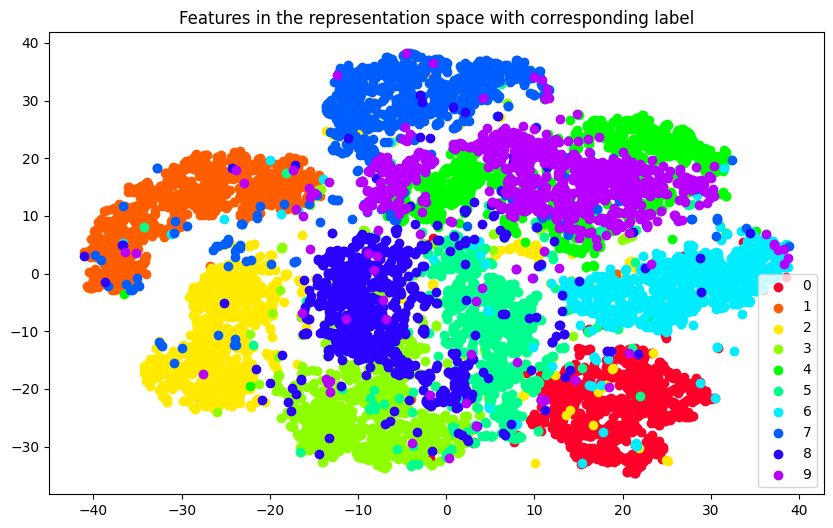

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Features in the representation space with corresponding label'}>)

In [54]:
## We use tSNE for our dimensionality reduction technique so we can
## plot the features using a 2D plot as it leads to nice plots.
## However, tSNE is tricky to use as a general dimensionality reduction method
## for clustering due to issues mentioned here: https://distill.pub/2016/misread-tsne/
## TSNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
## Nice article explaining shortcomings: https://distill.pub/2016/misread-tsne/

## Use these parameters, the plots are highly dependent on perplexity value
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500,n_jobs=-1)
representation_tsne = tsne.fit_transform(representation_auto_test)
plot_representation_label(representation_tsne, y_test)

You can also check how the reconstructed images look with the autoencoders you just trained.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


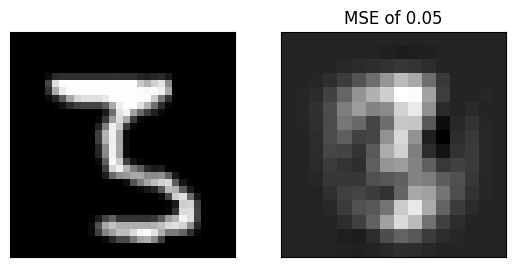

In [55]:
ind = np.random.randint(x_test.shape[0] -  1)
## The function below is defined in the tutorial
plot_recons_original(np.expand_dims(x_test_32[ind],0), y_test[ind], conv_autoencoder, size_image=(32,32))

## Task 2: Custom Loss Functions

In Image-to-Image tasks, researchers have found that an approach to improve the robustness of autoencoders is to replace the quadratic error with a loss function that is more robust to outliers.

There is a lot of interest in defining which loss function helps the most specific tasks. For instance, super-image resolution and image denoising may have different optimum loss functions, even though, they are trained in a very similar manner. Therefore, in this task, we will focus on using multiple loss functions to train an image denoise model. Sometimes, you may need to use a loss function that is not defined in Keras. If that happens, you can define it yourself and use it in the model.compile() module. We explain now how to do that.

You must define some variables:

* **True values** are those that we are aiming to generate, e.g. GT images.
* **Predicted values** are those that the network has generated,  e.g. denoised images.
* **Loss value** is the computed loss between true and predicted values,  e.g. MSE value.

The common structure for the custom loss method is as follows:

In [ ]:
def custom_loss(true_values, predicted_values):

  #     ...
  #     Define here your loss
  #     ...

  return []

We are going to use TinyImagenet, and add synthetic noise as before. This task requires a lot of RAM, thus, before starting it, please clean your RAM memory by restarting the Colab session.

In [56]:
# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_data(id_dict, split):

    print('starting loading data')
    data = []
    t = time.time()
    if split == 'train':
      total_im = 25000
      for key, value in id_dict.items():
          data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
          if len(data) > total_im:
            break
    else:
      total_im = 2500
      for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
          img_name, class_id = line.split('\t')[:2]
          data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))
          if len(data) > total_im:
            break
    print('finished loading data, in {} seconds'.format(time.time() - t))
    data = np.array(data).astype('float32')
    data /= 255.
    return data

x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594 (from 1)
Receiving objects: 100% (120594/120594), 212.68 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
starting loading data
finished loading data, in 1.7010440826416016 seconds
starting loading data
finished loading data, in 0.15734601020812988 seconds


We are going to use the UNet architecture for this task, however, you could use any autoencoder of your choice.

In [57]:
def UNet_model():

  inputs = layers.Input((64,64,3))

  ## Encoder part
  conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = layers.Dropout(rate=0.5)(conv4)
  pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = layers.Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop5))
  merge6 = layers.concatenate([drop4,up6], axis = 3)
  conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv6))
  merge7 = layers.concatenate([conv3,up7], axis = 3)
  conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv7))
  merge8 = layers.concatenate([conv2,up8], axis = 3)
  conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
  merge9 = layers.concatenate([conv1,up9], axis = 3)
  conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

  conv10 = layers.Conv2D(3, 3,  padding = 'same')(conv9)

  model = models.Model(inputs = inputs, outputs = conv10)

  return model

Now, an example of how to train UNet architecture with a custom MSE loss function:

In [58]:
def custom_loss(true_values, predicted_values):
    return backend.mean(backend.square(predicted_values - true_values), axis=-1)

model = UNet_model()
model.compile(optimizer = optimizers.Adam(learning_rate=1e-4), loss = custom_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with Custom loss): ', mse)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 125s 525ms/step - loss: 0.1345 - mse: 0.1345 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 9/10
178/178 ━━━━━━━━━━━━

Use the following code for evaluating and visualising examples:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


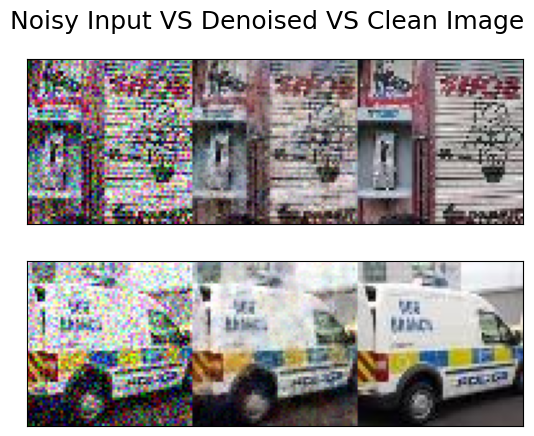

In [59]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Try to use a different loss function and see which one gives you the best result. Some well-known loss functions for image denoising are:

*  Structural Similarity Index ([SSIM](https://en.wikipedia.org/wiki/Structural_similarity))
*  Multiscale Structural Similarity Index ([MS-SSIM](https://ieeexplore.ieee.org/document/1292216?arnumber=1292216&tag=1))
* 1 / [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
* MAE
* [L0](https://arxiv.org/pdf/1803.04189.pdf)

Check the [Noise2Noise](https://arxiv.org/pdf/1803.04189.pdf) paper to learn more about alternative losses.

**Report:**
*  In this task, you are asked to build a table containing the MSE results on the test split of models trained with different loss functions. Use two or three different loss functions from the previous list and discuss the differences you observe. Report denoised images to support your arguments. You may need to modify the UNet model definition to use some of the previous losses.

Use the following code and write your custom loss function within the provided `custom_loss` method.



In [ ]:
def custom_loss(true_values, predicted_values):

  loss_value = 0

  #     ...

  #     Define here your loss

  #     ...

  return loss_value

model = UNet_model()
model.compile(optimizer = optimizers.Adam(learning_rate=1e-4), loss = custom_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

# SSIM

In [60]:
import tensorflow as tf
from tensorflow.keras import optimizers

def custom_loss(true_values, predicted_values):
    # Assuming pixel values are scaled between 0 and 1.
    # Compute SSIM over a window and then take the mean over the batch.
    ssim = tf.image.ssim(true_values, predicted_values, max_val=1.0)
    # Convert SSIM to a loss value (1 - SSIM) so that a perfect match gives a loss of 0.
    loss_value = 1 - tf.reduce_mean(ssim)
    return loss_value

model = UNet_model()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=custom_loss, metrics=['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 85s 426ms/step - loss: 0.6833 - mse: 1.3081 - val_loss: 0.4544 - val_mse: 0.7770
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 383ms/step - loss: 0.4529 - mse: 0.8404 - val_loss: 0.4238 - val_mse: 0.7664
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.4273 - mse: 0.8373 - val_loss: 0.4084 - val_mse: 0.7621
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 382ms/step - loss: 0.4132 - mse: 0.8337 - val_loss: 0.3950 - val_mse: 0.7617
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.4038 - mse: 0.8337 - val_loss: 0.3964 - val_mse: 0.7370
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 382ms/step - loss: 0.3963 - mse: 0.8265 - val_loss: 0.3818 - val_mse: 0.7680
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 382ms/step - loss: 0.3898 - mse: 0.8144 - val_loss: 0.3817 - val_mse: 0.7221
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.3819 - mse: 0.7124 - val_loss: 0.3725 - val_mse: 0.2782
Epoch 9/10
178/178 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


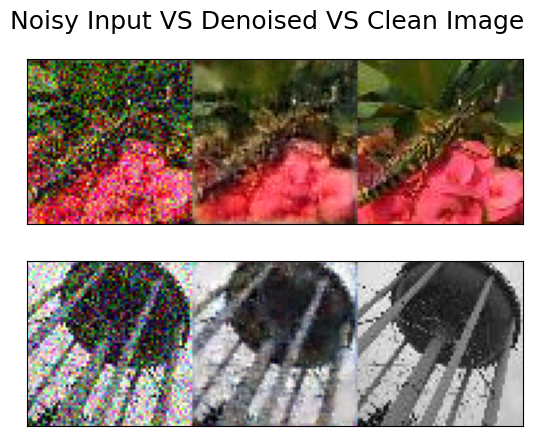

In [62]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

In [65]:
import tensorflow as tf
from tensorflow.keras import optimizers

def custom_loss(true_values, predicted_values):
    # Ensure your image pixel values are scaled between 0 and 1.
    psnr = tf.image.psnr(true_values, predicted_values, max_val=1.0)
    # Use the inverse of PSNR as loss: higher PSNR means lower loss.
    loss_value = 1.0 / psnr
    return loss_value

model = UNet_model()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=custom_loss, metrics=['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 400ms/step - loss: 0.1133 - mse: 0.3233 - val_loss: 0.0793 - val_mse: 0.0554
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 382ms/step - loss: 0.0748 - mse: 0.0466 - val_loss: 0.0654 - val_mse: 0.0301
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 379ms/step - loss: 0.0642 - mse: 0.0281 - val_loss: 0.0618 - val_mse: 0.0245
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 379ms/step - loss: 0.0609 - mse: 0.0233 - val_loss: 0.0595 - val_mse: 0.0213
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0586 - mse: 0.0202 - val_loss: 0.0570 - val_mse: 0.0182
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0565 - mse: 0.0174 - val_loss: 0.0550 - val_mse: 0.0158
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0544 - mse: 0.0151 - val_loss: 0.0539 - val_mse: 0.0146
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - loss: 0.0534 - mse: 0.0140 - val_loss: 0.0532 - val_mse: 0.0138
Epoch 9/20
178/178 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


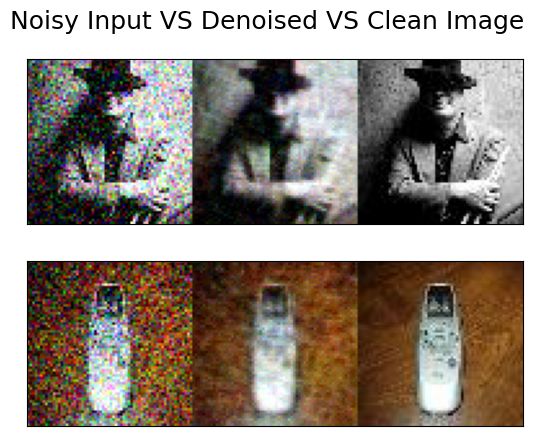

In [66]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

In [67]:
def custom_loss(true_values, predicted_values):
  loss_value = tf.reduce_mean(tf.abs(true_values - predicted_values))
  return loss_value


model = UNet_model()
model.compile(optimizer = optimizers.Adam(learning_rate=1e-4), loss = custom_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 84s 424ms/step - loss: 0.2163 - mse: 0.1311 - val_loss: 0.0903 - val_mse: 0.0137
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 384ms/step - loss: 0.0838 - mse: 0.0118 - val_loss: 0.0739 - val_mse: 0.0093
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.0710 - mse: 0.0086 - val_loss: 0.0672 - val_mse: 0.0078
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.0651 - mse: 0.0074 - val_loss: 0.0640 - val_mse: 0.0071
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.0617 - mse: 0.0067 - val_loss: 0.0614 - val_mse: 0.0066
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - loss: 0.0594 - mse: 0.0062 - val_loss: 0.0593 - val_mse: 0.0062
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.0578 - mse: 0.0059 - val_loss: 0.0584 - val_mse: 0.0060
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - loss: 0.0565 - mse: 0.0057 - val_loss: 0.0569 - val_mse: 0.0058
Epoch 9/10
178/178 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


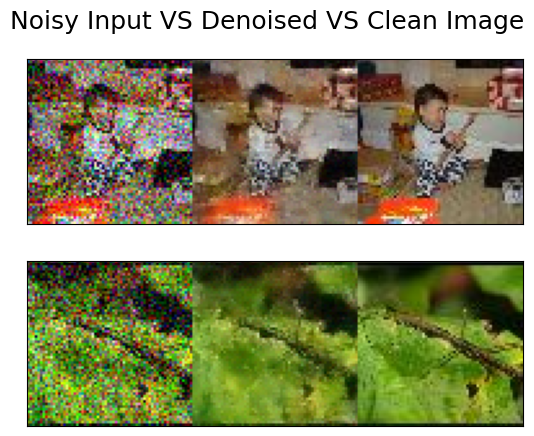

In [68]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col

    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])